# 使用 AutoML 訓練對象檢測模型
在本筆記本中，我們將介紹如何使用 AutoML 來訓練對象檢測模型。我們將使用一個小型數據集來訓練模型，演示如何調整模型的超參數以優化模型性能並將模型部署到推理場景中。有關詳細信息，請參閱 [AutoML for Images 的文檔](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models)。

## 環境設置
請按照 ["設置新的 conda 環境"](https://github.com/Azure/azureml-examples/tree/main/python-sdk/tutorials/automl-with-azureml#3-setup-a-new-conda-environment) 說明開始。

In [1]:
pip install azureml-sdk==1.39.0

     |████████████████████████████████| 2.5 MB 10.8 MB/s eta 0:00:01
     |████████████████████████████████| 136 kB 72.4 MB/s eta 0:00:01
     |████████████████████████████████| 8.6 MB 30.5 MB/s eta 0:00:01
     |████████████████████████████████| 313 kB 62.7 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 39.4 MB 45 kB/s s eta 0:00:01
     |████████████████████████████████| 228 kB 68.3 MB/s eta 0:00:01


     |████████████████████████████████| 13.6 MB 27.8 MB/s eta 0:00:01
ERROR: azureml-widgets 1.40.0 has requirement azureml-core~=1.40.0, but you'll have azureml-core 1.39.0.post1 which is incompatible.
ERROR: azureml-widgets 1.40.0 has requirement azureml-telemetry~=1.40.0, but you'll have azureml-telemetry 1.39.0 which is incompatible.
ERROR: azureml-train 1.40.0 has requirement azureml-train-core~=1.40.0, but you'll have azureml-train-core 1.39.0 which is incompatible.
ERROR: azureml-train-automl 1.40.0 has requirement azureml-automl-core~=1.40.0, but you'll have azureml-automl-core 1.39.1 which is incompatible.
ERROR: azureml-train-automl 1.40.0 has requirement azureml-dataset-runtime[fuse,pandas]~=1.40.0, but you'll have azureml-dataset-runtime 1.39.0 which is incompatible.
ERROR: azureml-train-automl 1.40.0 has requirement azureml-train-automl-client~=1.40.0, but you'll have azureml-train-automl-client 1.39.0 which is incompatible.
ERROR: azureml-train-automl-runtime 1.40.0.post1

    Uninstalling azureml-core-1.40.0:
      Successfully uninstalled azureml-core-1.40.0
  Attempting uninstall: azureml-pipeline-core
    Found existing installation: azureml-pipeline-core 1.40.0
    Uninstalling azureml-pipeline-core-1.40.0:
      Successfully uninstalled azureml-pipeline-core-1.40.0
  Attempting uninstall: azureml-telemetry
    Found existing installation: azureml-telemetry 1.40.0
    Uninstalling azureml-telemetry-1.40.0:
      Successfully uninstalled azureml-telemetry-1.40.0
  Attempting uninstall: azureml-dataprep-rslex
    Found existing installation: azureml-dataprep-rslex 2.4.0
    Uninstalling azureml-dataprep-rslex-2.4.0:
      Successfully uninstalled azureml-dataprep-rslex-2.4.0
  Attempting uninstall: azureml-dataprep
    Found existing installation: azureml-dataprep 3.0.0
    Uninstalling azureml-dataprep-3.0.0:
      Successfully uninstalled azureml-dataprep-3.0.0
  Attempting uninstall: azureml-dataset-runtime
    Found existing installation: azureml-

In [2]:
import azureml.core

print("This notebook was created using version 1.35.0 of the Azure ML SDK.")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK.")
assert (
    azureml.core.VERSION >= "1.35"
), "Please upgrade the Azure ML SDK by running '!pip install --upgrade azureml-sdk' then restart the kernel."

This notebook was created using version 1.35.0 of the Azure ML SDK.
You are currently using version 1.40.0 of the Azure ML SDK.


In [3]:
pip install torchvision==0.9.1

     |█████████████████████████       | 626.9 MB 60.1 MB/s eta 0:00:03     |█████████████████               | 426.9 MB 87.3 MB/s eta 0:00:05

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▏    | 682.8 MB 82.9 MB/s eta 0:00:02
     


     |███████████████████████████▍    | 687.0 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.0 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.0 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.1 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▍    | 687.2 MB 82.9 MB/s eta 0:00:02
     


     |███████████████████████████▌    | 691.3 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.3 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.3 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.4 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▌    | 691.5 MB 82.9 MB/s eta 0:00:02
     


     |███████████████████████████▊    | 695.6 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.6 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.6 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.6 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.6 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▊    | 695.7 MB 82.9 MB/s eta 0:00:02
     


     |███████████████████████████▉    | 699.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.8 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.9 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.9 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.9 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.9 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.9 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.9 MB 82.9 MB/s eta 0:00:02
     |███████████████████████████▉    | 699.9 MB 82.9 MB/s eta 0:00:02
     


     |████████████████████████████    | 704.1 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.1 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.1 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████    | 704.3 MB 82.9 MB/s eta 0:00:02
     


     |████████████████████████████▏   | 708.2 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.3 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.4 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.4 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.4 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▏   | 708.4 MB 82.9 MB/s eta 0:00:02
     


     |████████████████████████████▍   | 712.5 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.6 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.7 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.7 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▍   | 712.7 MB 82.9 MB/s eta 0:00:02
     


     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 716.9 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 717.0 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 717.0 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 717.0 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 717.0 MB 82.9 MB/s eta 0:00:02
     |████████████████████████████▌   | 717.0 MB 82.9 MB/s eta 0:00:02
     


     |████████████████████████████▊   | 721.2 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.2 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.2 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.2 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.2 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.2 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.3 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.3 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.3 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.3 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.3 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.3 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.3 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▊   | 721.3 MB 82.9 MB/s eta 0:00:01
     


     |████████████████████████████▉   | 725.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.5 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.6 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.6 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.6 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.6 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.6 MB 82.9 MB/s eta 0:00:01
     |████████████████████████████▉   | 725.6 MB 82.9 MB/s eta 0:00:01
     


     |█████████████████████████████   | 730.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.1 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.1 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.1 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.1 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.1 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████   | 730.1 MB 82.9 MB/s eta 0:00:01
     


     |█████████████████████████████▎  | 734.4 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.4 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.4 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.4 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▎  | 734.5 MB 82.9 MB/s eta 0:00:01
     


     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.8 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▍  | 738.9 MB 82.9 MB/s eta 0:00:01
     


     |█████████████████████████████▋  | 742.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 742.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 742.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 742.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 742.9 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     |█████████████████████████████▋  | 743.0 MB 82.9 MB/s eta 0:00:01
     


     |█████████████████████████████▊  | 747.2 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.2 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.3 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.4 MB 85.2 MB/s eta 0:00:01
     |█████████████████████████████▊  | 747.4 MB 85.2 MB/s eta 0:00:01
     


     |██████████████████████████████  | 751.6 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.6 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.6 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.6 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.6 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.6 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.7 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.7 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.7 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.7 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.7 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.7 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.7 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 751.7 MB 85.2 MB/s eta 0:00:01
     


     |██████████████████████████████  | 756.0 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.0 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.0 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.0 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.1 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████  | 756.2 MB 85.2 MB/s eta 0:00:01
     


     |██████████████████████████████▎ | 760.4 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.5 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.6 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.6 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▎ | 760.6 MB 85.2 MB/s eta 0:00:01
     


     |██████████████████████████████▍ | 764.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 764.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 765.0 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 765.0 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▍ | 765.0 MB 85.2 MB/s eta 0:00:01
     


     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.3 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.4 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.4 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.4 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.4 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▋ | 769.4 MB 85.2 MB/s eta 0:00:01
     


     |██████████████████████████████▉ | 773.7 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.8 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.9 MB 85.2 MB/s eta 0:00:01
     |██████████████████████████████▉ | 773.9 MB 85.2 MB/s eta 0:00:01
     


     |███████████████████████████████ | 778.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.3 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.3 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.3 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████ | 778.3 MB 85.2 MB/s eta 0:00:01
     


     |███████████████████████████████▏| 782.6 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.6 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.6 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▏| 782.8 MB 85.2 MB/s eta 0:00:01
     


     |███████████████████████████████▎| 787.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.1 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.2 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▎| 787.2 MB 85.2 MB/s eta 0:00:01
     


     |███████████████████████████████▌| 791.4 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.4 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.4 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.4 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.4 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▌| 791.5 MB 85.2 MB/s eta 0:00:01
     


     |███████████████████████████████▋| 795.6 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 795.6 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▋| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▊| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▊| 795.7 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▊| 795.8 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▊| 795.8 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▊| 795.8 MB 85.2 MB/s eta 0:00:01
     


     |███████████████████████████████▉| 799.9 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 799.9 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 799.9 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 799.9 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 799.9 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 799.9 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 799.9 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 799.9 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 800.0 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 800.0 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 800.0 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 800.0 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 800.0 MB 85.2 MB/s eta 0:00:01
     |███████████████████████████████▉| 800.0 MB 85.2 MB/s eta 0:00:01
     

     |████████████████████████████████| 804.1 MB 1.0 kB/s 
ERROR: azureml-automl-dnn-nlp 1.40.0 has requirement azureml-automl-core~=1.40.0, but you'll have azureml-automl-core 1.39.1 which is incompatible.
ERROR: azureml-automl-dnn-nlp 1.40.0 has requirement azureml-core~=1.40.0, but you'll have azureml-core 1.39.0.post1 which is incompatible.
ERROR: azureml-automl-dnn-nlp 1.40.0 has requirement azureml-telemetry~=1.40.0, but you'll have azureml-telemetry 1.39.0 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.10.2
    Uninstalling torch-1.10.2:
      Successfully uninstalled torch-1.10.2
Note: you may need to restart the kernel to use updated packages.


## 此時通過轉到菜單項Kernel並單擊“Restart”菜單項來重新啟動內核

In [1]:
pip freeze

absl-py==0.15.0
adal==1.2.7
adlfs==2022.2.0
aiohttp==3.8.1
aiohttp-cors==0.7.0
aioredis==1.3.1
aiosignal==1.2.0
alembic==1.7.7
ansiwrap==0.8.4
antlr4-python3-runtime==4.7.2
anyio==3.5.0
applicationinsights==0.11.10
arch==4.14
argcomplete==1.12.3
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asgiref==3.5.0
astroid==2.11.2
asttokens==2.0.5
astunparse==1.6.3
async-timeout==4.0.2
attrs==21.4.0
auto-tqdm==1.0.2
autokeras==1.0.16
autopep8==1.6.0
azure-appconfiguration==1.1.1
azure-batch==12.0.0
azure-cli==2.35.0
azure-cli-core==2.35.0
azure-cli-telemetry==1.0.6
azure-common==1.1.28
azure-core==1.21.1
azure-cosmos==3.2.0
azure-data-tables==12.2.0
azure-datalake-store==0.0.52
azure-graphrbac==0.61.1
azure-identity==1.7.0
azure-keyvault==1.1.0
azure-keyvault-administration==4.0.0b3
azure-keyvault-keys==4.5.0b6
azure-loganalytics==0.1.1
azure-mgmt-advisor==9.0.0
azure-mgmt-apimanagement==3.0.0
azure-mgmt-appconfiguration==2.1.0b2
azure-mgmt-applicationinsights==1.0.0
azure-mgmt-authorization=

Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import torch
import time
import torchvision
from PIL import Image
from typing import Any, Dict, List

## 工作區設置
為了在 Azure ML 中訓練和部署模型，首先需要設置一個工作區。

[Azure ML 工作區](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) 是一種 Azure 資源，用於組織和協調以下操作 許多其他 Azure 資源來幫助執行和共享機器學習工作流。特別是，Azure ML 工作區協調存儲、數據庫和計算資源，為機器學習試驗、部署、推理和部署模型的監視提供附加功能。

In [3]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
ws.get_details()


{'id': '/subscriptions/901e11c6-42ed-4fcc-875a-6bd77390af5b/resourceGroups/TWDayGroup/providers/Microsoft.MachineLearningServices/workspaces/twwsdemo',
 'name': 'twwsdemo',
 'identity': {'principal_id': 'a75a0dca-9aff-4185-9ac9-3002f4fd10e3',
  'tenant_id': 'ed483693-3413-4359-9fdf-53a3156196d5',
  'type': 'SystemAssigned'},
 'location': 'westus2',
 'type': 'Microsoft.MachineLearningServices/workspaces',
 'tags': {},
 'sku': 'Basic',
 'workspaceid': '5b38b9d7-e60b-4a28-9be1-a674b72bebe3',
 'sdkTelemetryAppInsightsKey': '19f24253-9564-406c-9a1e-a48a21b145aa',
 'description': '',
 'friendlyName': 'twwsdemo',
 'creationTime': '2022-05-02T23:26:15.2093891+00:00',
 'keyVault': '/subscriptions/901e11c6-42ed-4fcc-875a-6bd77390af5b/resourcegroups/twdaygroup/providers/microsoft.keyvault/vaults/twwsdemo7732395617',
 'applicationInsights': '/subscriptions/901e11c6-42ed-4fcc-875a-6bd77390af5b/resourcegroups/twdaygroup/providers/microsoft.insights/components/twwsdemo5328811544',
 'storageAccount': 

## 計算目標設置
您需要提供將用於您的 AutoML 的 [計算目標](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) 模型訓練。用於圖像任務的 AutoML 模型需要 [GPU SKU](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu)，例如來自 NC、NCv2、NCv3、ND、NDv2 的模型 和 NCasT4 系列。我們建議使用 NCsv3 系列（帶有 v100 GPU）來加快訓練速度。使用具有多 GPU VM SKU 的計算目標將利用多個 GPU 來加速訓練。此外，在調整模型的超參數時，設置具有多個節點的計算目標將允許通過利用並行性來加快模型訓練。

In [4]:
#Use this code if you are using a trial subscription that only allows for NCsV series to be created in a compute instance
import datetime
import time

from azureml.core.compute import ComputeTarget, ComputeInstance
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your instance
# Compute instance name should be unique across the azure region
#compute_name = "Imageprocessing2".format(ws._workspace_id)[:10]
#compute_name = "ImageImageprocessing2".format(ws._workspace_id)[:25]
compute_name = "TwGPUCompute"
print(compute_name)

# Verify that instance does not exist already
try:
    instance = ComputeInstance(workspace=ws, name=compute_name)
    print('Found existing instance, using it.')
except ComputeTargetException:
    print('Did not find existing instance, creating it.')
    compute_config = ComputeInstance.provisioning_configuration(
        vm_size='Standard_NC6',
        ssh_public_access=False,
        # vnet_resourcegroup_name='<my-resource-group>',
        # vnet_name='<my-vnet-name>',
        # subnet_name='default',
        # admin_user_ssh_public_key='<my-sshkey>'
    )
    instance = ComputeInstance.create(ws, compute_name, compute_config)
    instance.wait_for_completion(show_output=True)

TwGPUCompute
Found existing instance, using it.


In [5]:
#Use this code if you are using a "non" trial subscription that only allows for NCsV series to be created in a compute instance
#from azureml.core.compute import AmlCompute, ComputeTarget

#cluster_name = "Imageprocessing"

#try:
#    compute_target = ws.compute_targets[cluster_name]
#    print("Found existing compute target.")
#except KeyError:
#    print("Creating a new compute target...")
#    compute_config = AmlCompute.provisioning_configuration(
#        vm_size="Standard_NC6",
#        idle_seconds_before_scaledown=600,
#        min_nodes=0,
#        max_nodes=4,
#    )
#    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
#compute_target.wait_for_completion(
#    show_output=True, min_node_count=None, timeout_in_minutes=20
#)

## 实验设置
在您的工作区中创建一个 [实验](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) 以跟踪您的模型训练运行

In [6]:
from azureml.core import Experiment

experiment_name = "automl-image-object-detection_demo"
experiment = Experiment(ws, name=experiment_name)

## 带有输入训练数据的数据集

使用 AML 标记工具，您标记了图像并将注释导出为 AML ML 数据集。 现在我们需要一个 training_dataset 以使用其名称与该导出相关联。

In [7]:
from azureml.core import Dataset 
#training_dataset = Dataset.get_by_name(ws, name='alexamltest_20220307_214543')
training_dataset = Dataset.get_by_name(ws, name='soda_20220503_004555')

验证数据集是可选的。 如果未指定验证数据集，默认情况下 20% 的训练数据将用于验证。 您可以使用 `split_ratio` 参数控制百分比 - 请参阅 [文档](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image- 模型#model-agnostic-hyperparameters）了解更多细节。

In [8]:
training_dataset.to_pandas_dataframe()

,image_url,label,label_confidence,image_height,image_width
0,cvimageraw/137.jpg,"[{'label': 'coka', 'topX': 0.3502388691883373,...","[1.0, 1.0, 1.0]",616,816
1,cvimageraw/95.jpg,"[{'label': 'sprite', 'topX': 0.269186490346729...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",616,816
2,cvimageraw/118.jpg,"[{'label': 'sprite', 'topX': 0.304952226162332...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",616,816
3,cvimageraw/147.jpg,"[{'label': 'coka', 'topX': 0.41717149330181247...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",616,816
4,cvimageraw/229.jpg,"[{'label': 'sprite', 'topX': 0.219892016351457...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",616,816
...,...,...,...,...,...
235,cvimageraw/37.jpg,"[{'label': 'diet_coke', 'topX': 0.780077201536...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",616,816
236,cvimageraw/102.jpg,"[{'label': 'sprite', 'topX': 0.808165878644602...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",616,816
237,cvimageraw/105.jpg,"[{'label': 'diet_coke', 'topX': 0.641954787234...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",616,816
238,cvimageraw/66.jpg,"[{'label': 'sprite', 'topX': 0.636232392631993...","[1.0, 1.0, 1.0, 1.0]",616,816


## 为图像任务配置 AutoML 运行
AutoML 允许您轻松地训练模型以对图像数据进行图像分类、对象检测和实例分割。 您可以控制要使用的模型算法、为模型指定超参数值以及对超参数空间执行扫描以生成最佳模型。 使用“AutoMLImageConfig”指定配置 AutoML Image 运行的参数 - 请参阅 [文档](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) 了解可以使用的参数及其值的详细信息。

将 AutoML 用于图像任务时，您需要使用 `model_name` 参数指定模型算法。 您可以指定单个模型，也可以选择扫描多个模型。 请参阅[文档](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) 获取支持的模型算法列表。

### 使用指定算法的默认超参数值
在进行大规模扫描以搜索最佳模型和超参数之前，我们建议尝试给定模型的默认值以获得第一个基线。 接下来，您可以在扫描多个模型及其参数之前探索同一模型的多个超参数。 这允许使用迭代方法，例如多个模型和每个模型的多个超参数（正如我们在下一节中展示的那样），搜索空间呈指数增长，您需要更多的迭代来找到最佳配置。

如果您希望为给定算法使用默认超参数值（例如“yolov5”），您可以为 AutoML Image 运行指定配置，如下所示：

In [9]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_yolov5 = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,
    compute_target=compute_name,
    training_data=training_dataset,
    #validation_data=validation_dataset,
    hyperparameter_sampling=GridParameterSampling({"model_name": choice("yolov5"),'model_size': choice('small')}),
    iterations=1,
)

## 為計算機視覺任務提交 AutoML 運行
為運行創建配置設置後，您可以使用配置提交 AutoML 運行，以便使用訓練數據集訓練視覺模型。

In [10]:
automl_image_run = experiment.submit(image_config_yolov5)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-image-object-detection_demo,AutoML_b9adf7e6-e845-4e0f-ad89-013592ed9baa,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [11]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_b9adf7e6-e845-4e0f-ad89-013592ed9baa',
 'target': 'TwGPUCompute',
 'status': 'Completed',
 'startTimeUtc': '2022-05-03T00:59:17.845925Z',
 'endTimeUtc': '2022-05-03T01:11:34.489825Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'TwGPUCompute',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-image-object-detection_demo","subscription_id":"901e11c6-42ed-4fcc-875a-6bd77390af5b","resource_group":"TWDayGroup","workspace_name":"twwsdemo","region":"westus2","compute_target":"TwGPUCompute","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metri

在進行超參數掃描時，可視化使用 HyperDrive UI 嘗試的不同配置會很有用。您可以通過從上方轉到主 `automl_image_run` 的 UI 中的“子運行”選項卡導航到此 UI，這是 HyperDrive 父運行。然後您可以進入此 HyperDrive 父運行的“子運行”選項卡。或者，您可以在下面直接看到 HyperDrive 父運行並導航到其“子運行”選項卡：

## 從 AutoML 運行中註冊最優視覺模型
運行完成後，我們可以註冊從最佳運行（產生最佳主要指標的配置）創建的模型

In [12]:
# Register the model from the best run

best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties["model_name"]
model = best_child_run.register_model(
    model_name=model_name, model_path="outputs/model.pt"
)

## 下載模型和其他相關文件，例如 標籤

In [13]:
#https://github.com/MicrosoftDocs/azure-docs/blob/master/articles/machine-learning/how-to-inference-onnx-automl-image-models.md
# Create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

# Download the model from run history
best_child_run.download_file(name='train_artifacts/model.onnx',
output_file_path='./model/model.onnx')

best_child_run.download_file(name='train_artifacts/labels.json',
output_file_path='./model/labels.json')


### ***可選：如果您之前訓練過模型，您仍然可以使用 Run id 下載模型和標籤。從子運行的角度來看，這將是最高級別的運行 ID

In [14]:
# Select the best child run
# from azureml.train.automl.run import AutoMLRun
# import json

# run_id = "AutoML_0ce91e3f-1742-43a0-8b56-a6b5db5fbb42" # Specify the run ID
# automl_image_run = AutoMLRun(experiment=experiment, run_id=run_id)
# best_child_run = automl_image_run.get_best_child()

# labels_file = "./model/labels.json"
# best_child_run.download_file(name="train_artifacts/labels.json", output_file_path=labels_file)

# onnx_model_path = "./model/model.onnx"
# best_child_run.download_file(name="train_artifacts/model.onnx", output_file_path=onnx_model_path)

## 加載標籤和 ONNX 模型文件

In [15]:
import onnxruntime
import json

labels_file = "./model/labels.json"
onnx_model_path = "./model/model.onnx"


with open(labels_file) as f:
    classes = json.load(f)
print(classes)
try:
    session = onnxruntime.InferenceSession(onnx_model_path)
    print("ONNX model loaded...")
except Exception as e: 
    print("Error loading ONNX file: ",str(e))

['coka', 'diet_coke', 'sprite']
ONNX model loaded...


## 獲取 ONNX 模型的預期輸入和輸出詳細信息

In [16]:
sess_input = session.get_inputs()
sess_output = session.get_outputs()
print(f"No. of inputs : {len(sess_input)}, No. of outputs : {len(sess_output)}")

for idx, input_ in enumerate(range(len(sess_input))):
    input_name = sess_input[input_].name
    input_shape = sess_input[input_].shape
    input_type = sess_input[input_].type
    print(f"{idx} Input name : { input_name }, Input shape : {input_shape}, \
    Input type  : {input_type}")  

for idx, output in enumerate(range(len(sess_output))):
    output_name = sess_output[output].name
    output_shape = sess_output[output].shape
    output_type = sess_output[output].type
    print(f" {idx} Output name : {output_name}, Output shape : {output_shape}, \
    Output type  : {output_type}") 

No. of inputs : 1, No. of outputs : 4
0 Input name : input, Input shape : ['batch', 3, 640, 640],     Input type  : tensor(float)
 0 Output name : output, Output shape : ['batch', 25200, 8],     Output type  : tensor(float)
 1 Output name : 1006, Output shape : [1, 3, 80, 80, 8],     Output type  : tensor(float)
 2 Output name : 1354, Output shape : [1, 3, 40, 40, 8],     Output type  : tensor(float)
 3 Output name : 1702, Output shape : [1, 3, 20, 20, 8],     Output type  : tensor(float)


## 圖像推理預處理

In [17]:
#Determine the working directory for where the help module yolo_onnx_preprocessing_utils.py is stored
MODULE_FULL_PATH = !pwd

In [18]:
!pwd

/mnt/batch/tasks/shared/LS_root/mounts/clusters/twgpucompute/code/Users/lokinfey/AutoML


In [19]:
batch, channel, height_onnx, width_onnx = session.get_inputs()[0].shape
batch, channel, height_onnx, width_onnx

('batch', 3, 640, 640)

In [20]:
#Add the helper module yolo_onnx_preprocessing_utils to the system path where python looks for modules
import sys
sys.path.insert(1, MODULE_FULL_PATH)
import yolo_onnx_preprocessing_utils
from yolo_onnx_preprocessing_utils import preprocess

test_image_path = "test_image1.jpg"
img_data, pad = preprocess(test_image_path)

In [21]:
def get_predictions_from_ONNX(onnx_session,img_data):
    """perform predictions with ONNX Runtime
    
    :param onnx_session: onnx model session
    :type onnx_session: class InferenceSession
    :param img_data: pre-processed numpy image
    :type img_data: ndarray with shape 1xCxHxW
    :return: boxes, labels , scores 
    :rtype: list
    """
    sess_input = onnx_session.get_inputs()
    sess_output = onnx_session.get_outputs()
    # predict with ONNX Runtime
    output_names = [ output.name for output in sess_output]
    pred = onnx_session.run(output_names=output_names,\
                                               input_feed={sess_input[0].name: img_data})
    return pred[0]

result = get_predictions_from_ONNX(session, img_data)

## 使用 YOLO 進行對象檢測

In [22]:
print(result)

[[[4.5577126e+00 8.2495852e+00 1.5133790e+01 ... 5.8238983e-02
   2.9234767e-02 2.5655997e-01]
  [1.0575601e+01 9.1344891e+00 2.0536682e+01 ... 4.8190951e-02
   4.2262018e-02 3.4520096e-01]
  [1.6154627e+01 9.2209072e+00 2.7742535e+01 ... 5.7350606e-02
   5.1858664e-02 4.4835162e-01]
  ...
  [5.5386438e+02 6.3115308e+02 1.9605515e+02 ... 7.9967350e-02
   5.7769686e-02 4.5186111e-01]
  [5.8412061e+02 6.3096497e+02 2.0550772e+02 ... 8.7885231e-02
   5.4031074e-02 3.3454716e-01]
  [6.1047601e+02 6.3058337e+02 2.3236458e+02 ... 7.8152210e-02
   7.2322309e-02 1.8304726e-01]]]


In [23]:
from yolo_onnx_preprocessing_utils import non_max_suppression, _convert_to_rcnn_output
import torch

result = non_max_suppression(
    torch.from_numpy(result),
    conf_thres=.1,
    iou_thres=.5)
label, image_shape = _convert_to_rcnn_output(result[0], height_onnx, width_onnx, pad)
boxes = np.array(label["boxes"])
labels = np.array(label["labels"])
labels = [label[0] for label in labels]
scores = np.array(label["scores"])
scores = [score[0] for score in scores]
boxes, labels, scores

(array([[492.77072, 305.8546 , 546.72156, 418.72797],
        [399.95407, 300.72235, 457.54636, 428.85052],
        [310.2783 , 296.02405, 368.90237, 440.5022 ],
        [220.87881, 297.99402, 277.10373, 438.92212],
        [128.42532, 303.55576, 183.52777, 425.12784],
        [584.21875, 301.1958 , 637.94824, 407.1537 ]], dtype=float32),
 [0, 0, 0, 0, 0, 0],
 [0.7337006, 0.721315, 0.7135811, 0.6644167, 0.6570686, 0.6329423])

In [24]:
def _get_box_dims(image_shape, box):
    box_keys = ['topX', 'topY', 'bottomX', 'bottomY']
    height, width = image_shape[0], image_shape[1]

    box_dims = dict(zip(box_keys, [coordinate.item() for coordinate in box]))

    box_dims['topX'] = box_dims['topX'] * 1.0 / width
    box_dims['bottomX'] = box_dims['bottomX'] * 1.0 / width
    box_dims['topY'] = box_dims['topY'] * 1.0 / height
    box_dims['bottomY'] = box_dims['bottomY'] * 1.0 / height

    return box_dims

def _get_prediction(boxes, labels, scores, image_shape, classes):
    bounding_boxes = []
    for box, label_index, score in zip(boxes, labels, scores):
        box_dims = _get_box_dims(image_shape, box)

        box_record = {'box': box_dims,
                      'label': classes[label_index],
                      'score': score.item()}

        bounding_boxes.append(box_record)

    return bounding_boxes

bounding_boxes = _get_prediction(boxes, labels, scores, (height_onnx,width_onnx), classes)
print(json.dumps(bounding_boxes, indent=1))

# Filter the results with a threshold.
# Replace the threshold for your test scenario.
score_threshold = 0.6
filtered_bounding_boxes = []
for box in bounding_boxes:
    if box['score'] >= score_threshold:
       filtered_bounding_boxes.append(box)

[
 {
  "box": {
   "topX": 0.769954252243042,
   "topY": 0.47789783477783204,
   "bottomX": 0.8542524337768554,
   "bottomY": 0.6542624473571778
  },
  "label": "coka",
  "score": 0.7337005734443665
 },
 {
  "box": {
   "topX": 0.6249282360076904,
   "topY": 0.4698786735534668,
   "bottomX": 0.714916181564331,
   "bottomY": 0.6700789451599121
  },
  "label": "coka",
  "score": 0.7213150262832642
 },
 {
  "box": {
   "topX": 0.48480982780456544,
   "topY": 0.4625375747680664,
   "bottomX": 0.5764099597930908,
   "bottomY": 0.6882846832275391
  },
  "label": "coka",
  "score": 0.7135810852050781
 },
 {
  "box": {
   "topX": 0.3451231479644775,
   "topY": 0.46561565399169924,
   "bottomX": 0.43297457695007324,
   "bottomY": 0.6858158111572266
  },
  "label": "coka",
  "score": 0.6644166707992554
 },
 {
  "box": {
   "topX": 0.20066456794738768,
   "topY": 0.4743058681488037,
   "bottomX": 0.2867621421813965,
   "bottomY": 0.6642622470855712
  },
  "label": "coka",
  "score": 0.65706861019

(816, 616)
coka: 628.2826698303223, 397.41983940124516, 68.78731613159174, 108.64060134887696
coka: 509.9414405822754, 390.751104927063, 73.43016357421871, 123.32336730957029
coka: 395.6048194885254, 384.64624717712405, 74.74570770263672, 139.06021881103518
coka: 281.62048873901364, 387.2059778594971, 71.68676605224611, 135.64329681396484
coka: 163.74228744506834, 394.43275995254515, 70.2556205749512, 117.0131294250488
coka: 744.87890625, 391.36629364013675, 68.50510253906252, 101.98446502685545


<Figure size 1296x864 with 0 Axes>

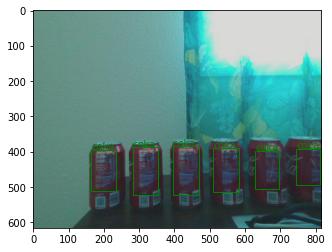

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
%matplotlib inline

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(test_image_path)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size
print(img.size)

fig,ax = plt.subplots(1)
# Display the image
ax.imshow(img_np)

# Draw a box and label for each detection 
for detect in filtered_bounding_boxes:
    label = detect['label']
    box = detect['box']
    ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
    topleft_x, topleft_y = x  * xmin, y *  1.35 *ymin
    width, height = x *  (xmax - xmin), y * (ymax - ymin)
    print('{}: {}, {}, {}, {}'.format(detect['label'], topleft_x, topleft_y, width, height))
    rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                             linewidth=1, edgecolor='green',facecolor='none')

    ax.add_patch(rect)
    color = 'green'
    plt.text(topleft_x, topleft_y, label, color=color)

plt.show()